In [2]:
# Import things from EMA Workbench

from ema_workbench import Policy, Scenario, perform_experiments
from ema_workbench import (RealParameter, CategoricalParameter, Constant,
                          ScalarOutcome)
from ema_workbench.connectors.pysd_connector import PysdModel
from ema_workbench.em_framework.outcomes import AbstractOutcome
from ema_workbench.em_framework.samplers import sample_uncertainties
from ema_workbench.em_framework.evaluators import LHS, SequentialEvaluator

from ema_workbench import save_results
from ema_workbench import ema_logging

from platypus import Problem, unique, nondominated, Real, EpsNSGAII
import functools
import pandas as pd
import numpy as np

ema_logging.log_to_stderr(ema_logging.INFO)

<Logger EMA (DEBUG)>

# Multi-Objective Optimization
At this point, there has been a basic policy structure implemented in the model, which can be found in `Levers.mdl` in the project repository. This script will run Platypus multi-objective optimization over that model, optimizing for the following outputs: 

* Minimize deceased population
* Minimize infectious population
* Maximize contact rate coefficient (where a larger value indicates less policy intervention)
* Maximize treatment rate coefficient (where a larger value indicates less policy intervention)

The first part of this script will take at least a few hours to run, but the output has been saved into `./platypus_results/original_model.csv`, which can be used for future visualization and analysis. 

In [2]:
#We can define common uncertainties and outcomes for each model:
uncertainties = [RealParameter('Average incubation time', 0.5, 14),
                 RealParameter('Average infectious period', 7, 21),
                 RealParameter('Basic reproduction number', 0.5, 5),
                 RealParameter('Case fatality rate', 0.01, 0.5), 
                 CategoricalParameter('Switch SEIR or SIR', [1,0])] 

outcomes = [ScalarOutcome('Deceased population'),
            ScalarOutcome('Infectious population'), 
            ScalarOutcome('contact rate coefficient'), 
            ScalarOutcome('treatment rate coefficient')]

robustness = [ScalarOutcome('Deceased population', kind=ScalarOutcome.MINIMIZE, function=np.max),
              ScalarOutcome('Infectious population', kind=ScalarOutcome.MINIMIZE, function=np.max), 
              ScalarOutcome('contact rate coefficient', kind=ScalarOutcome.MAXIMIZE, function=np.min), 
              ScalarOutcome('treatment rate coefficient', kind=ScalarOutcome.MAXIMIZE, function=np.min)]

# Ensure the proper constant values based on information above
constants = [Constant('Initial deceased population', 0),
             Constant('Initial exposed population', 0),
             Constant('Initial infectious population', 1),
             Constant('Initial recovered population', 0),
             Constant('Initial susceptible population', 100000)]

levers = [RealParameter("contact rate coefficient", 0.0001, 1),
          RealParameter("treatment rate coefficient", 0.0001, 1)]

In [3]:
mdl = PysdModel('Immunization', mdl_file='./models/02_SEIR_SIR_CoefficientLevers.mdl')

mdl.uncertainties = uncertainties
mdl.outcomes = outcomes
mdl.constants = constants
mdl.levers = levers
mdl.robustness = robustness
mdl.time_horizon = 360

In [5]:
n_scenarios = 50
scenarios = sample_uncertainties(mdl, n_scenarios)
nfe = 1000

with SequentialEvaluator(mdl) as evaluator:
    robust_results = evaluator.robust_optimize(mdl.robustness, scenarios, nfe=nfe,
                                  epsilons=[0.1,]*len(mdl.robustness), population_size=25)
    
robust_results.to_csv('./platypus_results/original_model.csv')

[MainProcess/INFO] performing 50 scenarios * 25 policies * 1 model(s) = 1250 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 125 cases completed
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 375 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 625 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 875 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1125 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 50 scenarios * 22 policies * 1 model(s) = 1100 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 110 cases completed
[MainProcess/INFO] 220 cases completed
[MainProcess/INFO] 330 cases completed
[MainProcess/INFO] 440 cases completed
[MainProcess/INFO] 550 cases completed
[MainProcess/INFO] 660 cases completed
[MainProcess/INFO] 770 cases completed
[MainP

In [6]:
robust_results.head()

,contact rate coefficient,treatment rate coefficient,Deceased population,Infectious population,contact rate coefficient,treatment rate coefficient
0,0.992647,0.252111,12140.843726,47833.938668,0.992647,0.252111
1,0.914379,0.521489,25106.818935,45342.738548,0.914379,0.521489
2,0.954655,0.919964,44546.234800,47118.746794,0.954655,0.919964
3,0.860198,0.714315,34391.187869,43451.948182,0.860198,0.714315
4,0.864192,0.458715,21995.107844,43376.608613,0.864192,0.458715


# Analysis of Basic Model Results

A parallel plot of the outputs from the multiobjective analysis reveal there is, overall, a linear relationship between the treatment rate coefficient, which represents potential policy impacts on the `Case fatality rate` parameter of the model, and `Deceased population`. That same linear relationship can be seen between the treatment rate cooefficient and `Infectiotus population`. These relationships reveal that by impacting the two key parameters with the coefficient structure described in the report (which can be seen in Levers.mdl, found in the project repository). 

In [8]:
import ParallelPlot
import seaborn as sns
import matplotlib.pyplot as plt

/Users/eebart/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/Users/eebart/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


In [9]:
def parsePlatypusData(): 

    file = './platypus_results/original_model.csv'
    results = pd.read_csv(file, index_col='Unnamed: 0')
    
    levers = results.ix[:,0:2]
    outcomes = results.ix[:,2:6]
    
    cols = ['treatment rate coefficient.1', 'Deceased population', 'Infectious population', 'contact rate coefficient.1']
    outcomes = outcomes[cols]
        
    return levers, outcomes

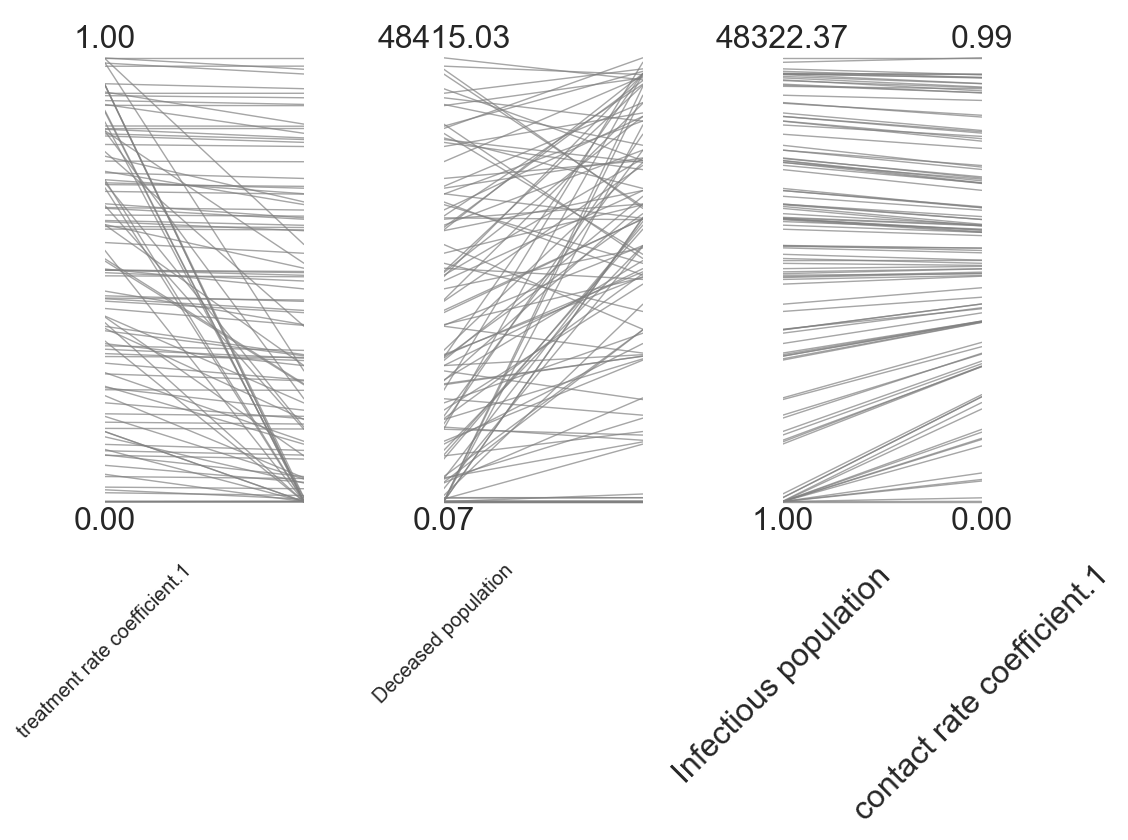

In [10]:
levers, outcomes = parsePlatypusData()

ParallelPlot.plot_optimal(outcomes, list(outcomes), '')

### Analysis of Coefficient Values

The charts, below, show that the highest density of treatment rate coefficient multipliers in the set of undominated solutions is around 0.6 (where 1 means there is no reduction in the `Basic reproduction number`). At the same time, the highest density of treatment rate coefficients is around 0.8 (again, where 1 means there is no reduction of `Case fatality rate`). These two facts indicate that in order to minimize both infection and death, more focus should be put on affecting the contact rate coefficient over the treatment rate coefficient when developing an adaptive policy plan. 

In [12]:
Contact = levers[levers.columns[0]]
treatment = levers[levers.columns[1]]

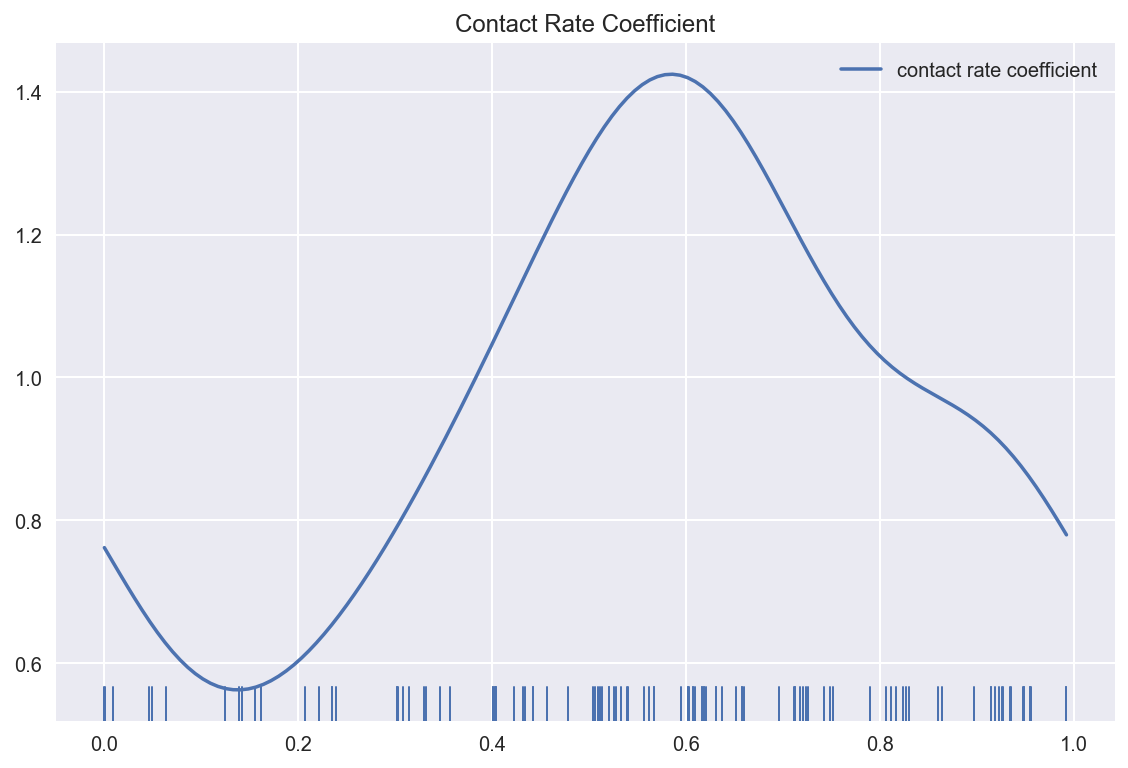

In [13]:
ax = plt.axes

sns.kdeplot(Contact, cut=0)
sns.rugplot(Contact)
sns.plt.title('Contact Rate Coefficient')

plt.legend()
plt.show()

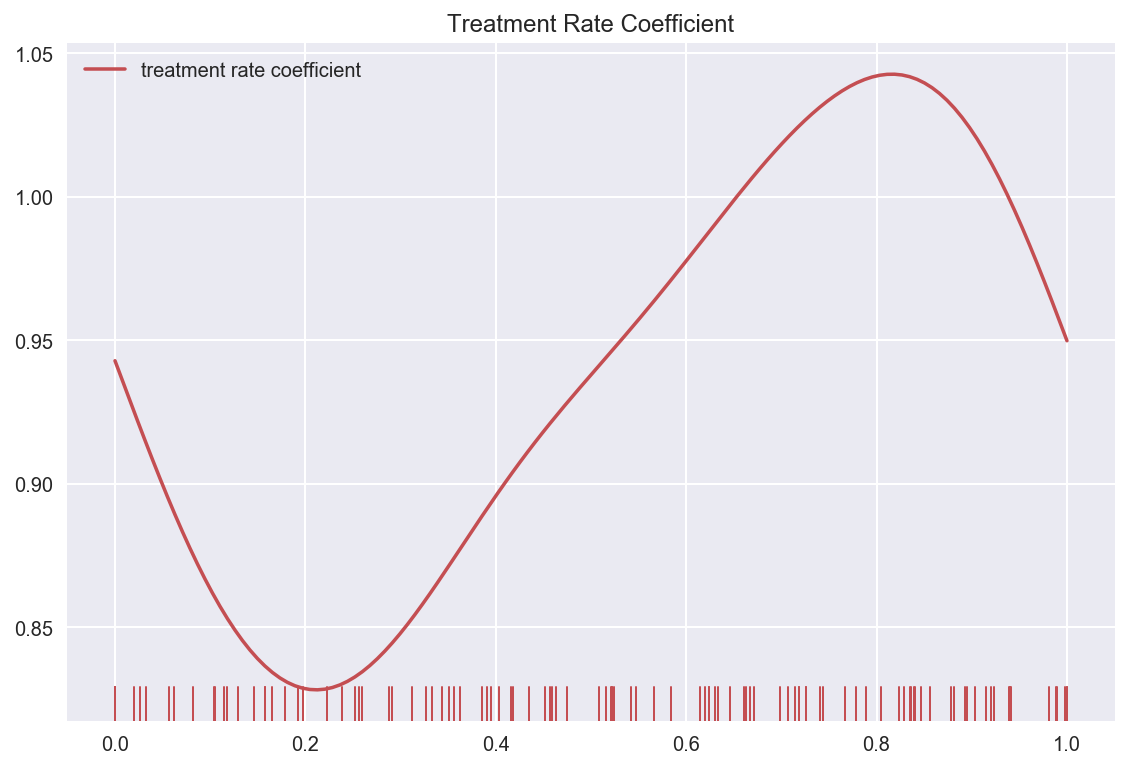

In [14]:
ax = plt.axes

sns.kdeplot(treatment, cut=0, color='r')
sns.rugplot(treatment, color='r')
sns.plt.title('Treatment Rate Coefficient')

plt.legend()
plt.show()